# US-Umb Parameter perturbation
 * Michigan broadleaf deciduous forest
 * 10 years, 2005-2014
 * Satellite phenology
 * forced with observed diffuse fraction
 * 300 ensemble members, varying 8 params
     * parameters are varying all at once (latin hypercube)
     * except for theta-cj and theta-ip, which are always equal to e/o
     * (so it's more like 7 params in reality)

# New for this ensemble:
- adding fnps, theta_psii to the ensemble
- tethering theta_cj, theta_ip
- remove wc2wj cap (allows lower j/v ratios)
- incorporate fluxnet observations

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Go get dask workers

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=12,
                     processes=12, memory="180GB",
                     project='P93300041',
                     walltime='2:00:00')
cluster.scale(12)
client = Client(cluster)

In [2]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=36,
                     processes=36, memory="100GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=1:ncpus=36:mem=109G',
                     walltime='03:00:00')
cluster.scale(36)
client = Client(cluster)

/glade/u/apps/ch/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [7]:
client

Client Scheduler: tcp://10.148.10.21:40161 Dashboard: http://10.148.10.21:37141/status,Cluster Workers: 36 Cores: 36 Memory: 100.08 GB


In [148]:
#client.close()

### Read in data

In [8]:
# some output information
thedir = '/glade/scratch/djk2120/UMBens2/'
f = 'US-UMB_GPPcap_LHC0100.clm2.h1.2005-01-01-00000.nc'
paths = sorted(glob.glob(thedir+'*.h1.*'))
ens = 1+np.arange(300)
ixpft = 7

In [9]:
# grab model output
%time ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',parallel='True')
ds['ens']=ens

CPU times: user 10.4 s, sys: 578 ms, total: 11 s
Wall time: 12.8 s


In [10]:
# grab forcing data
forcing = ['RAIN','SNOW','FSDS','FSDSVD','FSDSVI','RH']
basecase = ('/glade/scratch/djk2120/drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs/run/'+
            'drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs.clm2.h1.2005-01-01-00000.nc')
b = xr.open_dataset(basecase)
for v in forcing:
    ds[v]=b[v]

In [11]:
# set up parameter reads
paramlist = ['theta_ip',
    'theta_cj',
    'fnps',
    'jmaxb0',
    'jmaxb1',
    'wc2wjb0',
    'xl',
    'theta_psii']

def parampath(ee):
    thedir = '/glade/scratch/djk2120/UMBens2/'
    pref = 'US-UMB_GPPcap_LHC'
    suff = '.nc'
    return thedir+pref+str(ee).zfill(4)+suff

def get_params(paramlist,ee,ixpft):
    thepath = parampath(ee)
    ps = xr.open_dataset(thepath)
    x = {}
    if ee==1:
        print(str(ps['pftname'][ixpft].values)[2:].split(' ')[0])
    for p in paramlist:
        if p in ps.data_vars:
            pshape = ps[p].values.shape
            dims = len(pshape)
            if dims==0:
                x[p] = ps[p].values
            elif (dims==1)&(pshape[0]==1):
                x[p] = ps[p].values
            elif (dims==1):
                x[p] = ps[p][ixpft].values
            else:
                #kmax,ck,psi50,rootprof_beta
                #does not handle segment variation
                x[p] = ps[p][0,:].values 
    return x

In [12]:
# read in the parameter values
from joblib import Parallel, delayed
import joblib
with joblib.parallel_backend('dask'):
    %time param_output = Parallel()(delayed(get_params)(paramlist,ee,ixpft) for ee in ens)
# insert the parameter values into the dataset
nldir = '/glade/scratch/djk2120/UMBens2/'
for p in paramlist:
    if p in param_output[0]:
        x = np.array([param_output[i][p] for i in range(ens.size)])
    else:
        x = xr.open_dataset(nldir+p+'.nc')[p].values
    ds[p]=xr.DataArray(x,dims='ens')

CPU times: user 2.73 s, sys: 154 ms, total: 2.88 s
Wall time: 3.83 s


In [13]:
# get gpp from FLUXNET2015
f = '/glade/u/home/djk2120/umbcap/pyth/amflx2015/FLX_US-UMB_FLUXNET2015_SUBSET_HR_2000-2014_1-4.csv'
flnet = pd.read_csv(f)
gpp=flnet['GPP_DT_VUT_REF'].values
sw= flnet['SW_IN_F'].values
yr=np.floor(flnet['TIMESTAMP_START'].values/1e8)

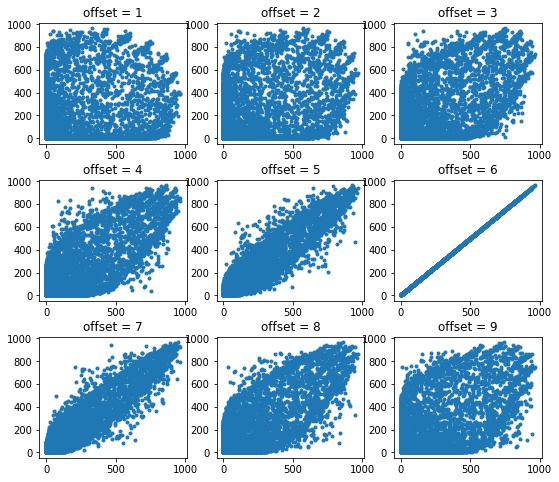

In [14]:
# figure out how to handle timezones
ix = ds['time.year']==2006
fsm = ds['FSDS'][ix].copy(deep=True)
fso = sw[yr==2006]

plt.figure(figsize=[9,8])
for i in 1+np.arange(9):
    plt.subplot(3,3,i)
    plt.plot(fso[:-i],fsm[i:],'.')
    plt.title('offset = '+str(i))
plt.subplots_adjust(hspace=0.3)    

In [15]:
#append gpp_obs to ds
offset = 6
yr_adj=np.zeros(np.shape(yr))+np.nan
yr_adj[:-offset]=yr[offset:]
gppobs = np.zeros(ds['FPSN'].sel(ens=1).size)+np.nan
for yy in 2005+np.arange(10):
    ix = ds['time.year']==yy
    nh = ix.sum().values
    tmp = gpp[yr_adj==yy]
    if tmp.size<nh:
        tmp2 = np.zeros([nh])+np.nan
        tmp2[:tmp.size]=tmp
        tmp = tmp2
    gppobs[ix]=tmp
ds['GPP_OBS']=xr.DataArray(gppobs,dims='time')
ds['mcsec']=ds['mcsec'][0,:]

### Some data analysis

In [16]:
x = (ds['FSDSVI']+ds['FSDSVD'])
ix1 = (x.values>300).ravel()
ix2 = ds['time.month']==6
ix = np.logical_and(ix1,ix2)
caps = [np.quantile(ds['FPSN'].sel(ens=ee)[ix],0.95) for ee in ens]

In [17]:
ix = caps==np.percentile(caps,50,interpolation='nearest')
ee = ens[ix]

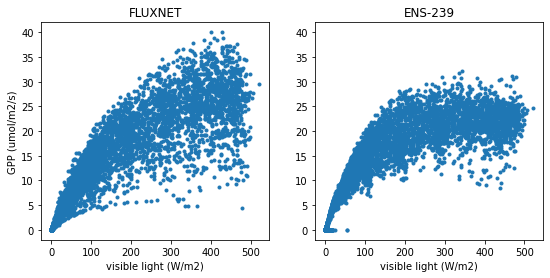

In [18]:
x = (ds['FSDSVI']+ds['FSDSVD'])
ix1 = ds['time.month']==6
ix2 = (x.values>0).ravel()
ix = np.logical_and(ix1,ix2)
y1 = ds['GPP_OBS'][ix]
y2 = ds['FPSN'].sel(ens=239)[ix]

plt.figure(figsize=[9,4])
plt.subplot(121)
plt.plot(x[ix],y1,'.')
plt.ylim([-2,42])
plt.xlabel('visible light (W/m2)')
plt.ylabel('GPP (umol/m2/s)')
plt.title('FLUXNET')
plt.subplot(122)
plt.plot(x[ix],y2,'.')
plt.ylim([-2,42])
plt.xlabel('visible light (W/m2)')
plt.title('ENS-239');

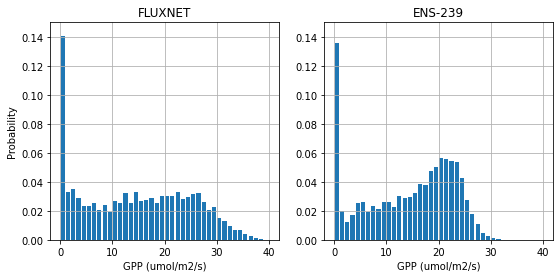

In [19]:
xv = np.arange(41)
n1 = np.zeros(40)
n2 = np.zeros(40)
for i in range(40):
    n1[i]=((y1>=xv[i])&(y1<xv[i+1])).sum()/ix.sum()
    n2[i]=((y2>=xv[i])&(y2<xv[i+1])).sum()/ix.sum()

plt.figure(figsize=[9,4])
plt.subplot(121)    
plt.bar(0.5+np.arange(40),n1)
plt.ylim([0,0.15])
plt.grid()
plt.title('FLUXNET')
plt.xlabel('GPP (umol/m2/s)')
plt.ylabel('Probability')
plt.subplot(122)    
plt.bar(0.5+np.arange(40),n2)
plt.ylim([0,0.15])
plt.grid()
plt.title('ENS-239');
plt.xlabel('GPP (umol/m2/s)');

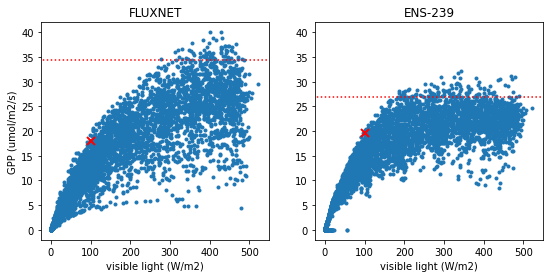

In [20]:
x = (ds['FSDSVI']+ds['FSDSVD'])
ix1 = ds['time.month']==6
ix2 = (x.values>0).ravel()
ix = np.logical_and(ix1,ix2)
y1 = ds['GPP_OBS'][ix]
y2 = ds['FPSN'].sel(ens=239)[ix]
ix2 = (x.values>300).ravel()
ixc = np.logical_and(ix1,ix2)
c1 = np.quantile(ds['GPP_OBS'][ixc],0.95)
c2 = np.quantile(ds['FPSN'].sel(ens=239)[ixc],0.95)
ix2 = np.ravel(np.logical_and(x>90,x<110))
ixs = np.logical_and(ix1,ix2)
s1 = np.quantile(ds['GPP_OBS'][ixs],0.95)
s2 = np.quantile(ds['FPSN'].sel(ens=239)[ixs],0.95)

plt.figure(figsize=[9,4])
plt.subplot(121)
plt.plot(x[ix],y1,'.')
plt.plot([-100,600],[c1,c1],'r:')
plt.plot(100,s1,'rx',mew=2,markersize=8)
plt.xlim([-25,550])
plt.ylim([-2,42])
plt.xlabel('visible light (W/m2)')
plt.ylabel('GPP (umol/m2/s)')
plt.title('FLUXNET')

plt.subplot(122)
plt.plot(x[ix],y2,'.')
plt.plot([-100,600],[c2,c2],'r:')
plt.plot(100,s2,'rx',mew=2,markersize=8)
plt.xlim([-25,550])
plt.ylim([-2,42])
plt.xlabel('visible light (W/m2)')
plt.title('ENS-239');

In [30]:
xf = 24*60*60*12/1e6
obsiav = np.std(xf*ds['GPP_OBS'].groupby('time.year').mean(dim=xr.ALL_DIMS).values[:-1])
x = (ds['FSDSVI']+ds['FSDSVD'])
ix1 = ds['time.month']==6
ix2 = np.ravel(x>300)
ix = np.logical_and(ix1,ix2)
obscap = np.quantile(ds['GPP_OBS'][ix],0.95)
iav = [np.std(xf*ds['FPSN'].sel(ens=ee).groupby('time.year').mean(dim=xr.ALL_DIMS).values[:-1])
       for ee in ens]

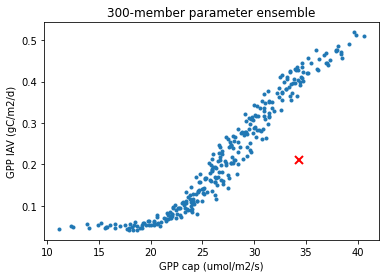

In [31]:
plt.plot(caps,iav,'.')
plt.plot(obscap,obsiav,'rx',mew=2,markersize=8)
plt.ylabel('GPP IAV (gC/m2/d)')
plt.xlabel('GPP cap (umol/m2/s)');
plt.title('300-member parameter ensemble');

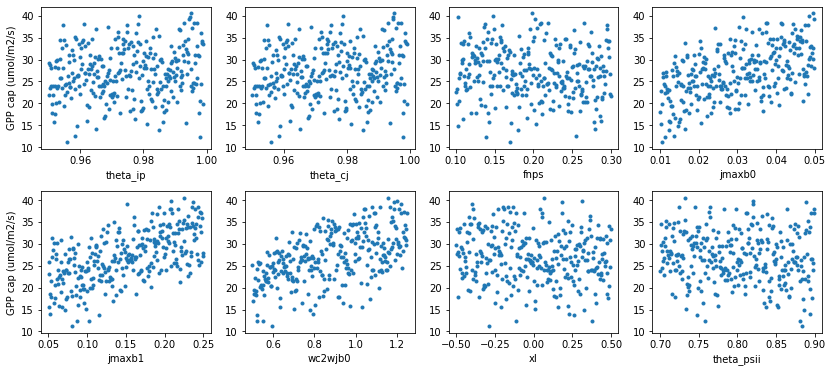

In [22]:
plt.figure(figsize=[14,6])
for i,p in zip(range(8),paramlist):
    plt.subplot(2,4,i+1)
    plt.plot(ds[p],caps,'.')
    plt.xlabel(p)
    if (i==0)|(i==4):
        plt.ylabel('GPP cap (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [24]:
params = paramlist[1:]
params

['theta_cj', 'fnps', 'jmaxb0', 'jmaxb1', 'wc2wjb0', 'xl', 'theta_psii']

/glade/u/apps/ch/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/glade/u/apps/ch/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


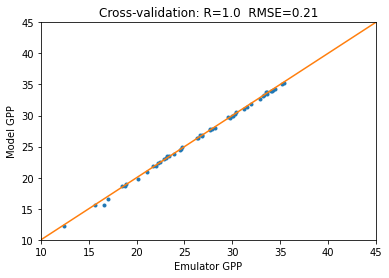

In [25]:
f = np.array(caps)
mins = ds[params].min()
maxs = ds[params].max()
ix = ds['ens']<250
X = np.hstack((ds[p][ix].values.reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) 
              for p in params)
y = f[ix].reshape(-1,1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.02, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

ix = ds['ens']>=250
X = np.hstack((ds[p][ix].values.reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) 
              for p in params)
y = f[ix].reshape(-1,1)
y_pred, sigma = gp.predict(X, return_std=True)
rmse = np.round(np.sqrt(np.mean(np.square(y_pred-y))),2)
r    = np.round(gp.score(X,y),2)
plt.plot(y_pred,y,'.')
the_lims=[10,45]
plt.plot(the_lims,the_lims)
plt.xlim(the_lims)
plt.ylim(the_lims)
plt.xlabel('Emulator GPP')
plt.ylabel('Model GPP')
plt.title('Cross-validation: R='+str(r)+'  RMSE='+str(rmse));

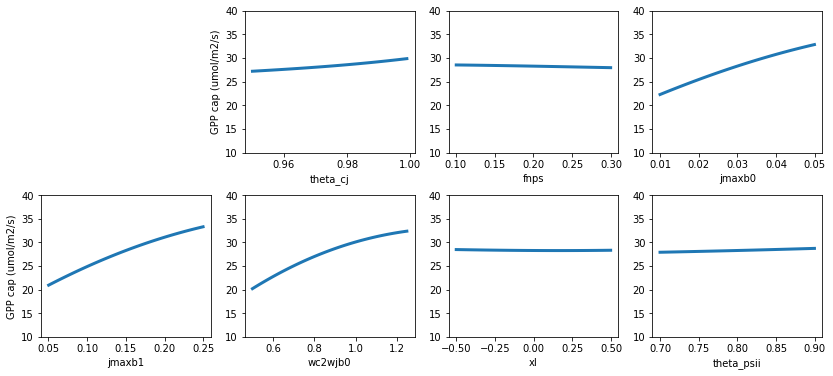

In [26]:
plt.figure(figsize=[14,6])
for i,p in zip(range(7),params):
    X = np.zeros([100,7])+0.5
    X[:,i]=np.linspace(0,1,100)
    x = np.linspace(0,1,100)*(maxs[p].values-mins[p].values)+mins[p].values
    plt.subplot(2,4,i+2)
    plt.plot(x,gp.predict(X),linewidth=3)
    plt.xlabel(p)
    plt.ylim([10,40])
    if (i==0)|(i==3):
        plt.ylabel('GPP cap (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

In [27]:
ix1 = ds['time.month']==6
ix2 = np.ravel(ds['FSDS']>0)
ix = np.logical_and(ix1,ix2)
err = ds['FPSN'][:,ix,0] - ds['GPP_OBS'][ix]
MSE = (err**2).groupby('ens').mean(dim=xr.ALL_DIMS).values
RMSE=MSE**(0.5)

In [33]:
x = (ds['FSDSVI']+ds['FSDSVD'])
ix1 = ds['time.month']==6
ix2 = np.ravel(np.logical_and(x>90,x<110))
ixs = np.logical_and(ix1,ix2)
slopes = [np.quantile(ds['FPSN'].sel(ens=ee)[ixs],0.95)/100 for ee in ens]
gpp100 = [np.quantile(ds['FPSN'].sel(ens=ee)[ixs],0.95) for ee in ens]

obs_cap=34.4
obs_slope=0.18


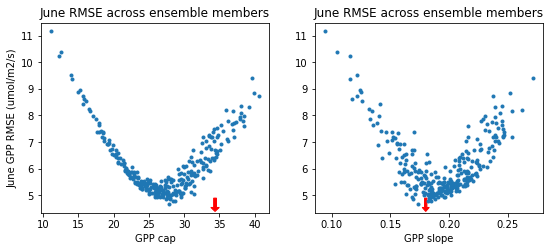

In [34]:
x = (ds['FSDSVI']+ds['FSDSVD'])
ix1 = ds['time.month']==6
ix2 = np.ravel(x>300)
ix = np.logical_and(ix1,ix2)
obscap = np.quantile(ds['GPP_OBS'][ix],0.95)
obsslope  = np.quantile(ds['GPP_OBS'][ixs],0.95)/100
obsgpp100 = np.quantile(ds['GPP_OBS'][ixs],0.95)
plt.figure(figsize=[9,3.5])
plt.subplot(121)
plt.plot(caps,RMSE,'.')
plt.arrow(obscap,4.9,0,-0.5,width=0.4,length_includes_head=True,head_length=0.15,color='red')
plt.xlabel('GPP cap')
plt.ylabel('June GPP RMSE (umol/m2/s)');
plt.title('June RMSE across ensemble members');
plt.subplot(122)
plt.plot(slopes,RMSE,'.')
plt.arrow(obsslope,4.9,0,-0.5,width=0.002,length_includes_head=True,head_length=0.15,color='red')
plt.xlabel('GPP slope')
plt.title('June RMSE across ensemble members');

print('obs_cap='+str(np.round(obscap,1)))
print('obs_slope='+str(np.round(obsslope,2)))

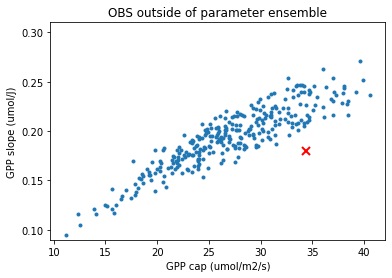

In [35]:
plt.plot(caps,slopes,'.')
plt.plot(obscap,obsslope,'rx',mew=2,markersize=8)
plt.ylim([0.09,0.31])
plt.yticks(np.arange(5)/20+0.1)
plt.ylabel('GPP slope (umol/J)')
plt.xlabel('GPP cap (umol/m2/s)')
plt.title('OBS outside of parameter ensemble');


/glade/u/apps/ch/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/glade/u/apps/ch/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


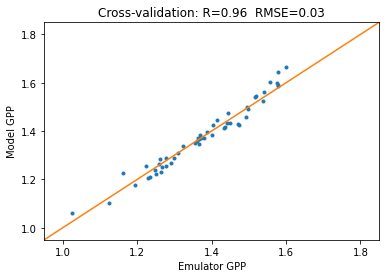

In [36]:
f = np.array(caps)/np.array(gpp100)
mins = ds[params].min()
maxs = ds[params].max()
ix = ds['ens']<250
X = np.hstack((ds[p][ix].values.reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) 
              for p in params)
y = f[ix].reshape(-1,1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp2 = GaussianProcessRegressor(kernel=kernel, alpha=0.02, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp2.fit(X, y)

ix = ds['ens']>=250
X = np.hstack((ds[p][ix].values.reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) 
              for p in params)
y = f[ix].reshape(-1,1)
y_pred, sigma = gp2.predict(X, return_std=True)
rmse = np.round(np.sqrt(np.mean(np.square(y_pred-y))),2)
r    = np.round(gp2.score(X,y),2)
plt.plot(y_pred,y,'.')
the_lims=[0.95,1.85]
plt.plot(the_lims,the_lims)
plt.xlim(the_lims)
plt.ylim(the_lims)
plt.xlabel('Emulator GPP')
plt.ylabel('Model GPP')
plt.title('Cross-validation: R='+str(r)+'  RMSE='+str(rmse));

OBS multiple= 1.91


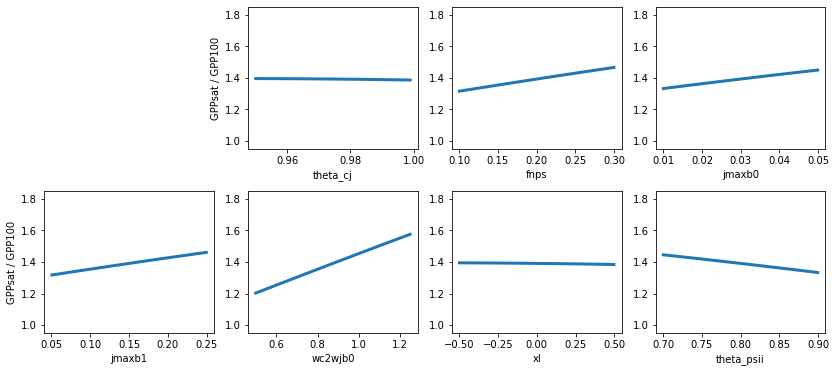

In [37]:
plt.figure(figsize=[14,6])
for i,p in zip(range(7),params):
    X = np.zeros([100,7])+0.5
    X[:,i]=np.linspace(0,1,100)
    x = np.linspace(0,1,100)*(maxs[p].values-mins[p].values)+mins[p].values
    plt.subplot(2,4,i+2)
    plt.plot(x,gp2.predict(X),linewidth=3)
    plt.xlabel(p)
    plt.ylim([0.95,1.85])
    if (i==0)|(i==3):
        plt.ylabel('GPPsat / GPP100')
plt.subplots_adjust(hspace=0.3)
obsmult = obscap/obsgpp100
print('OBS multiple= '+str(np.round(obsmult,2)))

In [38]:
def calcost(x):
    thiscap   = gp.predict(x)
    thismult  = gp2.predict(x)
    cost = ((thiscap-obscap)/obscap)**2+((thismult-obsmult)/obsmult)**2
    return np.ravel(cost)

In [39]:
adder = np.zeros([98,7])
ct = -1
for i in range(7):
    ct = ct+1
    adder[ct,i]=0.01
    ct = ct+1
    adder[ct,i]=-0.01
    for j in 1+i+np.arange(6-i):
        ct = ct+1
        adder[ct,i]=0.01
        adder[ct,j]=0.01
        ct = ct+1
        adder[ct,i]=-0.01
        adder[ct,j]=-0.01
        ct = ct+1
        adder[ct,i]=0.01
        adder[ct,j]=-0.01
        ct = ct+1
        adder[ct,i]=-0.01
        adder[ct,j]=0.01
        

theta_cj=0.37
fnps=0.99
jmaxb0=0.5
jmaxb1=0.9
wc2wjb0=0.99
xl=0.5
theta_psii=0.01


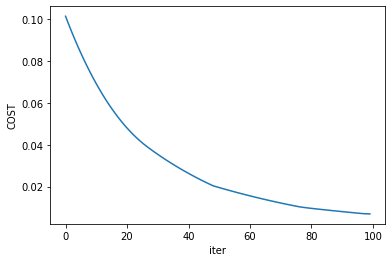

In [40]:
ot = np.linspace(0,97,98)
x = np.zeros([1,7])+0.5

nx = 100
cv = np.zeros(nx)
for i in range(nx):
    xmat = x+adder
    nogood = np.max(xmat,axis=1)>1
    xmat[nogood,:]=0
    nogood = np.min(xmat,axis=1)<0
    xmat[nogood,:]=0
    c = calcost(xmat)
    ix = int(ot[c==c.min()][0])
    x = x+adder[ix,:]
    cv[i]=c.min()
plt.plot(cv)
plt.xlabel('iter')
plt.ylabel('COST')
for i,p in zip(range(7),params):
    print(p+'='+str(np.round(x[0,i],2)))

In [41]:
print('cap='+str(np.round(gp.predict(x)[0][0],1)))
print('slope='+str(np.round(gp2.predict(x)[0][0],2)))

cap=35.1
slope=1.76


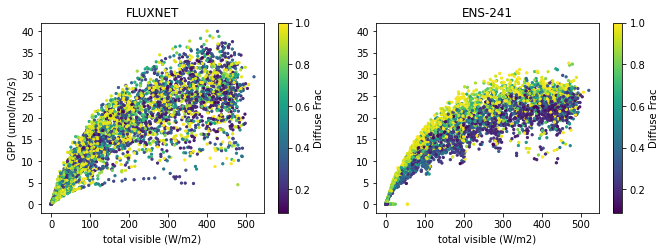

In [42]:
ix = np.logical_and(np.ravel(ds['FSDS']>0),ds['time.month']==6)
x=(ds['FSDSVD']+ds['FSDSVI']).values.ravel()
dff = (ds['FSDSVI']/ (ds['FSDSVD']+ds['FSDSVI'])).values.ravel()


ee = ens[RMSE==RMSE.min()][0]
plt.figure(figsize=[11,3.5])
plt.subplot(121)
plt.scatter(x[ix],ds['GPP_OBS'][ix],s=5,c=dff[ix])
plt.ylim([-2,42])
plt.xlabel('total visible (W/m2)')
plt.ylabel('GPP (umol/m2/s)')
c=plt.colorbar()
plt.title('FLUXNET')
c.set_label('Diffuse Frac')
plt.subplot(122)
plt.scatter(x[ix],ds['FPSN'].sel(ens=ee)[ix],s=5,c=dff[ix])
plt.ylim([-2,42])
plt.xlabel('total visible (W/m2)')
c=plt.colorbar()
c.set_label('Diffuse Frac')
plt.title('ENS-241');

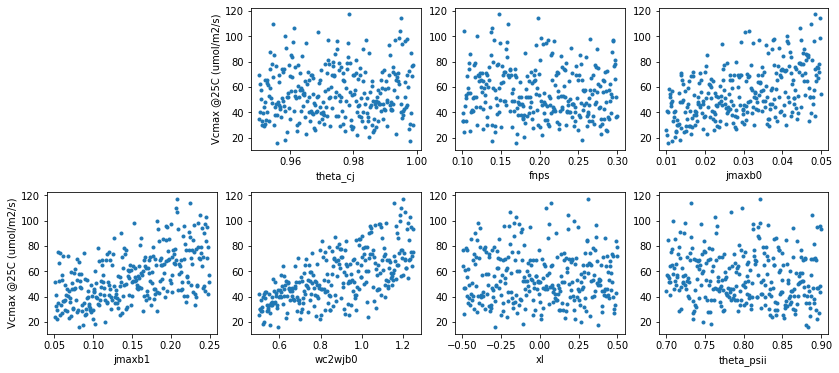

In [43]:
ix = ds['time.month']==6
vc_june = ds['Vcmx25Z'][:,ix].groupby('ens').mean(dim=xr.ALL_DIMS).values
plt.figure(figsize=[14,6])
for i,p in zip(range(7),params):
    plt.subplot(2,4,i+2)
    plt.plot(ds[p],vc_june,'.')    
    plt.xlabel(p)
    if (i==0)|(i==3):
        plt.ylabel('Vcmax @25C (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

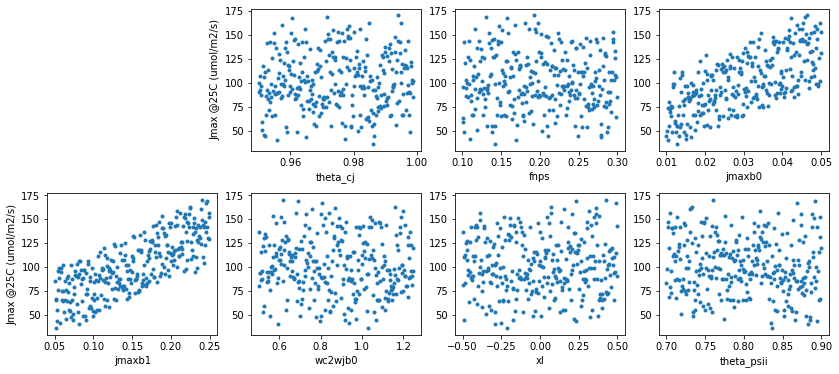

In [44]:
ix = ds['time.month']==6
j_june = ds['Jmx25Z'][:,ix].groupby('ens').mean(dim=xr.ALL_DIMS).values
plt.figure(figsize=[14,6])
for i,p in zip(range(7),params):
    plt.subplot(2,4,i+2)
    plt.plot(ds[p],j_june,'.')    
    plt.xlabel(p)
    if (i==0)|(i==3):
        plt.ylabel('Jmax @25C (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

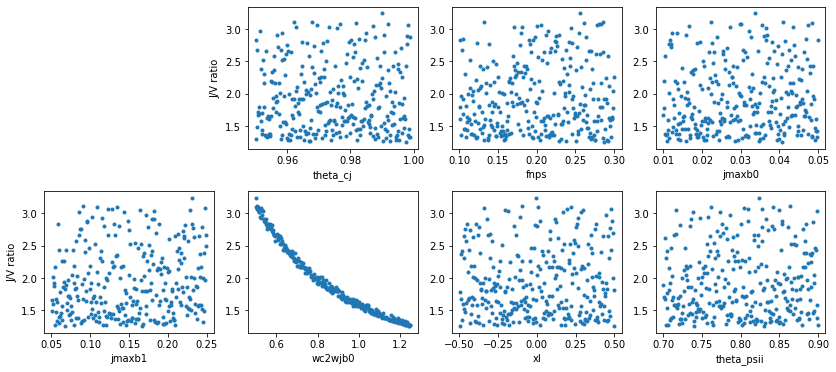

In [45]:
plt.figure(figsize=[14,6])
for i,p in zip(range(7),params):
    plt.subplot(2,4,i+2)
    plt.plot(ds[p],j_june/vc_june,'.')    
    plt.xlabel(p)
    if (i==0)|(i==3):
        plt.ylabel('J/V ratio')
plt.subplots_adjust(hspace=0.3)

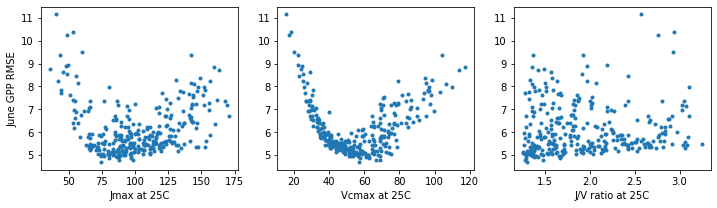

In [57]:
plt.figure(figsize=[12,3])
plt.subplot(131)
plt.plot(j_june,RMSE,'.')
plt.xlabel('Jmax at 25C')
plt.ylabel('June GPP RMSE')
plt.subplot(132)
plt.plot(vc_june,RMSE,'.')
plt.xlabel('Vcmax at 25C')
plt.subplot(133)
plt.plot(j_june/vc_june,RMSE,'.')
plt.xlabel('J/V ratio at 25C');

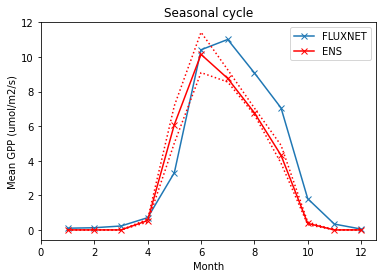

In [46]:
ix = ds['time.year']<2015
obs_monthly_mean = ds['GPP_OBS'][ix].groupby('time.month').mean(dim=xr.ALL_DIMS).values
ens_monthly_means = np.array([ds['FPSN'].sel(ens=ee)[ix].groupby('time.month').mean(dim=xr.ALL_DIMS).values
                              for ee in ens])
avg = np.mean(ens_monthly_means,axis=0)
q75 = [np.quantile(ens_monthly_means[:,i],0.75) for i in range(12)]
q25 = [np.quantile(ens_monthly_means[:,i],0.25) for i in range(12)]



plt.plot(1+np.arange(12),obs_monthly_mean,'-x')
plt.plot(1+np.arange(12),avg,'-rx')
plt.plot(1+np.arange(12),q25,':r')
plt.plot(1+np.arange(12),q75,':r')
plt.title('Seasonal cycle')
plt.xticks(2*np.arange(7))
plt.xlabel('Month')
plt.ylabel('Mean GPP (umol/m2/s)')
plt.legend(['FLUXNET','ENS']);

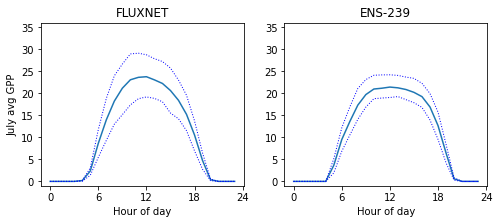

In [47]:
ds2 = ds.swap_dims({'time':'mcsec'})
ix = ds2['time.month']==6

ee = 239
gpp_d = ds2['GPP_OBS'][ix].groupby('mcsec').mean(dim=xr.ALL_DIMS).values
gpp_d = np.concatenate([gpp_d[6:],gpp_d[:6]])
mm = np.unique(ds2['mcsec'])
gpp_25 = [np.quantile(ds2['GPP_OBS'][np.logical_and(ix,ds2['mcsec']==m)],0.25) for m in mm]
gpp_25 = np.concatenate([gpp_25[6:],gpp_25[:6]])
gpp_75 = [np.quantile(ds2['GPP_OBS'][np.logical_and(ix,ds2['mcsec']==m)],0.75) for m in mm]
gpp_75 = np.concatenate([gpp_75[6:],gpp_75[:6]])

gpp_2 = ds2['FPSN'].sel(ens=ee)[ix].groupby('mcsec').mean(dim=xr.ALL_DIMS).values
gpp_2 = np.concatenate([gpp_2[6:],gpp_2[:6]])
gpp_25_e = [np.quantile(ds2['FPSN'].sel(ens=ee)[np.logical_and(ix,ds2['mcsec']==m)],0.25) for m in mm]
gpp_25_e = np.concatenate([gpp_25_e[6:],gpp_25_e[:6]])
gpp_75_e = [np.quantile(ds2['FPSN'].sel(ens=ee)[np.logical_and(ix,ds2['mcsec']==m)],0.75) for m in mm]
gpp_75_e = np.concatenate([gpp_75_e[6:],gpp_75_e[:6]])

plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(gpp_d)
plt.plot(gpp_25,':',color='blue',linewidth=1)
plt.plot(gpp_75,':',color='blue',linewidth=1)

plt.xticks(6*np.arange(5));
plt.title('FLUXNET')
plt.ylabel('July avg GPP')
plt.ylim([-1,36])
plt.xlabel('Hour of day')

plt.subplot(122)
plt.plot(gpp_2)
plt.plot(gpp_25_e,':',color='blue',linewidth=1)
plt.plot(gpp_75_e,':',color='blue',linewidth=1)
plt.xticks(6*np.arange(5));
plt.title('ENS-'+str(ee));
plt.ylim([-1,36])
plt.xlabel('Hour of day');


In [48]:
plt.plot(caps,ds['FPSN'][:,ix].groupby('ens').mean(dim=xr.ALL_DIMS),'.')
plt.plot(obscap,ds['GPP_OBS'][ix].mean(),'x',color='red',mew=3,markersize=10)
plt.xlabel('GPP cap')
plt.ylabel('Mean GPP')

IndexError: Boolean indexer should be unlabeled or on the same dimension to the indexed array. Indexer is on ('mcsec',) but the target dimension is time.